### Analysis of tweets

In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
import pandas as pd
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from scipy.sparse import coo_matrix, hstack
import matplotlib.pyplot as plt
import seaborn as sns

#### Loading data from the IAC data files

In [3]:
avg_df = pd.read_csv('qr_averages.csv')

In [4]:
qr_df = pd.read_csv('qr_meta.csv')

In [5]:
df = qr_df.merge(avg_df,on='key')

In [6]:
df = df[['key','quote','response','agreement']]

In [7]:
df.head()

,key,quote,response,agreement
0,"(731, 1)",I remember looking at the classic evolutionary...,Why do you find it necessary to fit observatio...,-1.333333
1,"(660, 3)",So they (pro-life peeps) say abortion is murde...,"Yes, you are missing something. How come age d...",0.285714
2,"(114, 5)",'If the solar system was brought about by an a...,"C.S.Lewis believes things on faith, yet we are...",-1.500000
3,"(43, 3)",...to ToE because it means genetic evolution i...,"Well, it might help if you could propose a mec...",-0.833333
4,"(1314, 0)",Sir Issac Newton was an idiot and you are a ge...,"You really think so? Im flattered, but I think...",-1.666667


In [8]:
df = df[~df['agreement'].isna()]

#### Create class label from the 'agreement' scores

In [9]:
def get_class(x):
    if np.isnan(x):
        return x
    if x>=-5 and x<=0 :
        return "disagreement"
    else:
        return "agreement"
        

In [10]:
df['agreement_class'] = df.apply(lambda row:get_class(row['agreement']),axis=1)

In [11]:
df['agreement_class'].value_counts()

disagreement    8007
agreement       1973
Name: agreement_class, dtype: int64

In [12]:
df.drop(columns='agreement',inplace=True)

### Creating features

##### Sentiment of the quote and the response

In [13]:
sia = SIA()

In [14]:
def get_sentiment(x):
    return sia.polarity_scores(x)['compound']

In [15]:
df['sentiment_quote'] = df.apply(lambda row:get_sentiment(row['quote']),axis=1)
df['sentiment_response'] = df.apply(lambda row:get_sentiment(row['response']),axis=1)

##### Similarity score between quote and the response

In [16]:
def count_common_words(q,r):
    q_words = set(q.split(' '))
    r_words = set(r.split(' '))
    
    return len(q_words.intersection(r_words))

In [17]:
df['similarity'] = df.apply(lambda row:count_common_words(row['quote'],row['response']),axis=1)

#### Count the number of negation words in the quote and the response

In [18]:
def count_neg(x):
    neg = ['no','never','nobody','none','dont','neither',"don't","isn't",'does not',"hadn't","won't"]
    
    words = [word.lower() for word in x.split(" ")]
    
    neg_words = [word for word in words if word in neg]
    
    return len(neg_words)

In [19]:
df['neg_words_quote'] = df.apply(lambda row:count_neg(row['quote']),axis=1)

In [20]:
df['neg_words_response'] = df.apply(lambda row:count_neg(row['response']),axis=1)

#### Count the number of words in the quote and the response

In [21]:
df['len_quote'] = df.apply(lambda row:len(row['quote'].split(' ')),axis=1)

In [22]:
df['len_response'] = df.apply(lambda row:len(row['response'].split(' ')),axis=1)

In [23]:
df_train,df_test,y_train,y_test = train_test_split(df[["quote","response","sentiment_quote","sentiment_response",'similarity','neg_words_quote','neg_words_response','len_quote','len_response']],df['agreement_class'])


In [24]:
df_train.head()

,quote,response,sentiment_quote,sentiment_response,similarity,neg_words_quote,neg_words_response,len_quote,len_response
8589,At least I&#8217;m not advocating hauling astr...,"Er, they are held to the same standards. ID fa...",0.2023,0.0516,4,0,0,49,17
1189,"First, are you not forcing your beliefs on me ...","Ummm, no. How could I possibly be forcing my b...",-0.4404,-0.2960,7,0,0,27,35
7250,"As theorized, the concept of evolution is anal...",I would suggest you look at the faero island m...,0.9485,0.0000,13,2,0,263,27
3865,"the problem is, if evolution is indeed true, t...","Without the Fall, Jesus would have no need to ...",0.6908,-0.2960,4,1,1,60,23
7768,I would have to say that whoever told you abou...,Actually what sank that debate was a bunch of ...,0.0258,0.4939,7,0,0,35,49


#### Creating numerical vectors from the words of the quote and the response

In [25]:
vect_quote = TfidfVectorizer(stop_words='english',min_df=2,
                       token_pattern=r'\b[a-zA-Z0-9\']+\b', ngram_range=(2,4))

In [26]:
transf_train_quote = vect_quote.fit_transform(df_train.quote)
transf_test_quote = vect_quote.transform(df_test.quote)

In [27]:
vect_response = TfidfVectorizer(stop_words='english',min_df=2,
                       token_pattern=r'\b[a-zA-Z0-9\']+\b', ngram_range=(2,4))

In [28]:
transf_train_response = vect_response.fit_transform(df_train.response)
transf_test_response = vect_response.transform(df_test.response)

In [29]:
df_train_sparse = hstack([transf_train_quote,transf_train_response,df_train[['sentiment_quote','sentiment_response','similarity','neg_words_quote','neg_words_response','len_quote','len_response']]]).toarray()


In [30]:
df_test_sparse = hstack([transf_test_quote,transf_test_response,df_test[['sentiment_quote','sentiment_response','similarity','neg_words_quote','neg_words_response','len_quote','len_response']]]).toarray()
                                                                           

##### Training a logistic regression model

In [31]:
np.mean(cross_val_score(LogisticRegression(C=10), df_train_sparse, y_train, cv=5, scoring='roc_auc'))

0.613728156857043

In [32]:
logreg=LogisticRegression(C=10,multi_class="multinomial",solver = 'lbfgs')

In [33]:
logreg.fit(df_train_sparse, y_train)

/anaconda2/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [34]:
y_pred = logreg.predict(df_test_sparse)

In [36]:
y_test_new = []
for i in y_test.values:
    if i=='agreement':
        y_test_new.append(0)
    elif i=='none':
        y_test_new.append(1)
    else:
        y_test_new.append(2)

In [37]:
y_pred_new = []
for i in y_pred:
    if i=='agreement':
        y_pred_new.append(0)
    elif i=='none':
        y_pred_new.append(1)
    else:
        y_pred_new.append(2)

In [39]:
roc_auc_score(y_test_new,y_pred_new)

0.5019128578175165

##### Load the twitter interactions data 

In [40]:
interactions_df = pd.read_csv('May3_interactions.csv')

In [41]:
interactions_df.head()

,Unnamed: 0,created_at,id,text,retweets,retweet_count,user_screenname,in_reply_to_screen_name,in_reply_to_status_id,quoted_status,hashtags,user_mentions,type_of_interaction,quoted_text_original,quoted_text_original_screenname,retweeting_orig_screenname,orig_text_replied_to,orig_author_replied_to,interactions,final_interactions
0,0,2019-05-03 17:56:09,1124372085114122240,The stakes are high for our community! Fla cou...,<bound method Status.retweets of Status(_api=<...,2,RepDarrenSoto,NaN,NaN,NaN,['ForThePeople'],['HouseDemocrats'],Dem->Dem,NaN,NaN,NaN,NaN,NaN,NaN,Dem->Dem
1,1,2019-05-02 17:13:10,1123998878934740992,Here’s a link to our Supplement to Puerto Rico...,<bound method Status.retweets of Status(_api=<...,4,RepDarrenSoto,RepDarrenSoto,1.123999e+18,NaN,[],[],NaN,NaN,NaN,NaN,Here’s a link to our Puerto Rico Recovery Blue...,RepDarrenSoto,Dem->Dem,Dem->Dem
2,2,2019-05-02 17:11:59,1123998583575990273,Here’s a link to our Puerto Rico Recovery Blue...,<bound method Status.retweets of Status(_api=<...,2,RepDarrenSoto,RepDarrenSoto,1.123994e+18,NaN,[],[],NaN,NaN,NaN,NaN,In @NRDems Cmte with Gov @ricardorossello disc...,RepDarrenSoto,Dem->Dem,Dem->Dem
3,3,2019-05-01 21:22:55,1123699344388055040,@RepDarrenSoto meets with Seminole Members @G...,<bound method Status.retweets of Status(_api=<...,2,RepDarrenSoto,NaN,NaN,NaN,[],"['SeminoleEC', 'RepDarrenSoto', 'GladesElecCoo...",Dem->Dem,NaN,NaN,SeminoleEC,NaN,NaN,NaN,Dem->Dem
4,4,2019-05-01 15:10:12,1123605547985584129,Great meeting with @RepDarrenSoto and Sr. Leg...,<bound method Status.retweets of Status(_api=<...,2,RepDarrenSoto,NaN,NaN,NaN,[],"['GregPheneger', 'RepDarrenSoto']",Dem->Dem,NaN,NaN,GregPheneger,NaN,NaN,NaN,Dem->Dem


In [42]:
quotes_df = interactions_df[interactions_df['retweeting_orig_screenname'].isna()]

In [43]:
user_mentions = quotes_df[quotes_df['retweeting_orig_screenname'].isna() & quotes_df['orig_author_replied_to'].isna()]


In [44]:
retweets_df = interactions_df[~interactions_df['retweeting_orig_screenname'].isna()]

In [45]:
def get_response(x):
    if isinstance(x['quoted_text_original_screenname'],str):
        return (x['quoted_text_original'])
    else:
        return (x['orig_text_replied_to'])

In [46]:
quotes_df['response'] = quotes_df.apply(lambda row: get_response(row),axis=1)

In [47]:
quotes_df = quotes_df[~(quotes_df['response'].isna())]


In [48]:
new_df = quotes_df[['text','response']]

##### Create the above mentioned features for the twitter interactions corpus

In [49]:
new_df['sentiment_quote'] = new_df.apply(lambda row:get_sentiment(row['text']),axis=1)
new_df['sentiment_response'] = new_df.apply(lambda row:get_sentiment(row['response']),axis=1)

In [50]:
new_df['similarity'] = new_df.apply(lambda row:count_common_words(row['text'],row['response']),axis=1)

In [51]:
new_df['neg_words_quote'] = new_df.apply(lambda row:count_neg(row['text']),axis=1)

new_df['neg_words_response'] = new_df.apply(lambda row:count_neg(row['response']),axis=1)

new_df['len_quote'] = new_df.apply(lambda row:len(row['text'].split(' ')),axis=1)

new_df['len_response'] = new_df.apply(lambda row:len(row['response'].split(' ')),axis=1)

##### vectorise the quote and the response pairs in the twitter interactions corpus

In [52]:
new_df_quote = vect_quote.transform(new_df.text)
new_df_response = vect_response.transform(new_df.response)

In [53]:
new_df_sparse = hstack([new_df_quote,new_df_response,new_df[['sentiment_quote','sentiment_response','similarity','neg_words_quote','neg_words_response','len_quote','len_response']]]).toarray()


#### Predict the class labels "agreement"/"disagreement" for the twitter quote-response pairs

In [54]:
y_pred = logreg.predict(new_df_sparse)

In [55]:
new_df['interaction'] = quotes_df['final_interactions']

In [56]:
new_df['class'] = y_pred

#### All the tweets that are retweeted are assigned the class "agreement"

In [57]:
retweets_df['class'] = 'agreement'

#### The tweets in the user-mentioned df are assigned a class according to the sentiment of the text

In [58]:
def get_sentiment2(x):
    sentiment= sia.polarity_scores(x)['compound']
    if sentiment>0:
        return "agreement"
    else:
        return "disagreement"

In [59]:
user_mentions['class'] = user_mentions.apply(lambda row:get_sentiment2(row['text']),axis=1)


In [60]:
new_df.rename(index=str, columns={"interaction": "final_interactions"},inplace=True)

#### Joining the separate dataframes into one

In [61]:
concatenated_df = pd.concat([user_mentions[['final_interactions','class']],retweets_df[['final_interactions','class']],new_df[['final_interactions','class']]],axis=0)


In [62]:
concatenated_df.head()

,final_interactions,class
0,Dem->Dem,disagreement
11,Dem->Dem,agreement
12,Dem->Dem,disagreement
14,Dem->Dem,disagreement
16,Dem->Dem,disagreement


### Scoring : Positive Intergroup Reciprocity

In [64]:
conc_df1 = concatenated_df[concatenated_df['final_interactions']=='Dem->Dem']
len(conc_df1[conc_df1['class']=='agreement'])/len(conc_df1)

0.6280566280566281

In [65]:
conc_df2 = concatenated_df[concatenated_df['final_interactions']=='Rep->Rep']
len(conc_df2[conc_df2['class']=='agreement'])/len(conc_df2)

0.8740875912408759

In [66]:
conc_df3 = concatenated_df[concatenated_df['final_interactions']=='Rep->Dem']
len(conc_df3[conc_df3['class']=='agreement'])/len(conc_df3)

0.6896551724137931

In [67]:
conc_df4 = concatenated_df[concatenated_df['final_interactions']=='Dem->Rep']
len(conc_df4[conc_df4['class']=='agreement'])/len(conc_df4)

0.717948717948718

In [68]:
scores_df = pd.DataFrame({'Republican':[0.874,0.689],'Democrat':[0.717,0.631]},index=['Republican','Democrat'])

In [69]:
scores_df

,Republican,Democrat
Republican,0.874,0.717
Democrat,0.689,0.631


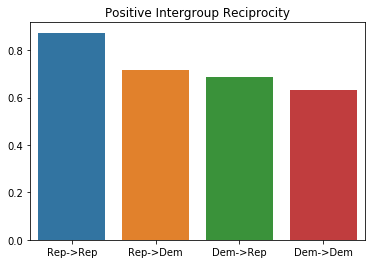

In [70]:
#plt.figure(figsize=(10,8))
interactions = ['Rep->Rep','Rep->Dem', 'Dem->Rep','Dem->Dem']
scores = [0.874,0.717,0.689, 0.631]
sns.barplot(x=interactions,y=scores)
plt.title('Positive Intergroup Reciprocity')
plt.show()

#### Count of retweets within and between each group

In [71]:
dd_retweet_cnt = len(retweets_df[retweets_df['type_of_interaction']=='Dem->Dem'])
rr_retweet_cnt = len(retweets_df[retweets_df['type_of_interaction']=='Rep->Rep'])
rd_retweet_cnt = len(retweets_df[retweets_df['type_of_interaction']=='Rep->Dem'])
dr_retweet_cnt = len(retweets_df[retweets_df['type_of_interaction']=='Dem->Rep'])

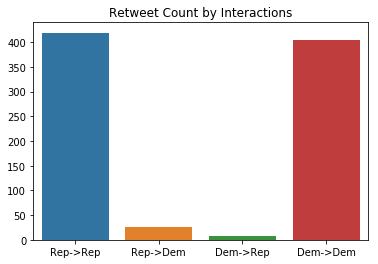

In [72]:
interactions = ['Rep->Rep','Rep->Dem', 'Dem->Rep','Dem->Dem']
scores = [rr_retweet_cnt,rd_retweet_cnt,dr_retweet_cnt, dd_retweet_cnt]
sns.barplot(x=interactions,y=scores)
plt.title('Retweet Count by Interactions')
plt.show()

#### Count of user mentions within and between each group

In [73]:
dd_user_mentions_cnt = len(user_mentions[user_mentions['final_interactions']=='Dem->Dem'])
rr_user_mentions_cnt = len(user_mentions[user_mentions['final_interactions']=='Rep->Rep'])
rd_user_mentions_cnt = len(user_mentions[user_mentions['final_interactions']=='Rep->Dem'])
dr_user_mentions_cnt = len(user_mentions[user_mentions['final_interactions']=='Dem->Rep'])

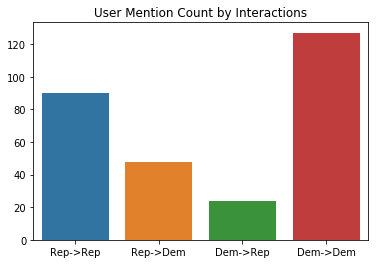

In [74]:
interactions = ['Rep->Rep','Rep->Dem', 'Dem->Rep','Dem->Dem']
scores = [rr_user_mentions_cnt,rd_user_mentions_cnt,dr_user_mentions_cnt, dd_user_mentions_cnt]
sns.barplot(x=interactions,y=scores)
plt.title('User Mention Count by Interactions')
plt.show()

#### Count of quoted tweets within and between each group

In [75]:
dd_quoted_cnt = len(new_df[new_df['final_interactions']=='Dem->Dem'])
rr_quoted_cnt = len(new_df[new_df['final_interactions']=='Rep->Rep'])
rd_quoted_cnt = len(new_df[new_df['final_interactions']=='Rep->Dem'])
dr_quoted_cnt = len(new_df[new_df['final_interactions']=='Dem->Rep'])

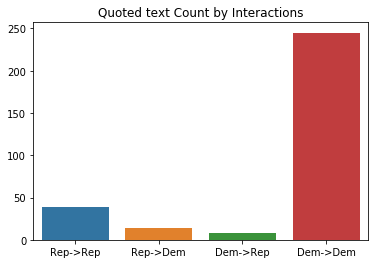

In [76]:
interactions = ['Rep->Rep','Rep->Dem', 'Dem->Rep','Dem->Dem']
scores = [rr_quoted_cnt,rd_quoted_cnt,dr_quoted_cnt, dd_quoted_cnt]
sns.barplot(x=interactions,y=scores)
plt.title('Quoted text Count by Interactions')
plt.show()